In [79]:
import sys
sys.path.append('../..')
import datetime

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

confirmed_cases = cov19.get_jhu_confirmed_cases()

date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = cov19.get_last_date(confirmed_cases)
#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 12 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 21
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days

country = 'Germany'

cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_median_lambda = 1,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.5,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.25,
                      pr_sigma_lambda = 1)]

model_rw = cov19.SEIR_with_extensions(np.diff(cases_obs),
                                    change_points,
                                    date_begin_sim,
                                    num_days_sim,
                                    diff_data_sim, 
                                   N=83e6,
                                   priors_dict=dict(pr_sigma_random_walk=0.1,
                                                    pr_sigma_lambda_0=1,
                                                    pr_median_lambda_0=2),
                                   with_random_walk=True)


model_not_rw = cov19.SEIR_with_extensions(np.diff(cases_obs),
                                    change_points,
                                    date_begin_sim,
                                    num_days_sim,
                                    diff_data_sim, 
                                   N=83e6,
                                   priors_dict=None,
                                   with_random_walk=False)

trace_rw = pm.sample(model=model_rw, init='advi', draws=3000)
trace_not_rw = pm.sample(model=model_not_rw, init='advi', draws=3000)
# advi is important as initialization, other initializations methods lead
# to more divergences
path_to_save = '../../figures/'

pr_beta_I_begin was set to default value 100
pr_beta_E_begin_scale was set to default value 10
pr_median_mu was set to default value 0.3333333333333333
pr_sigma_mu was set to default value 0.3
pr_median_delay was set to default value 5
pr_sigma_delay was set to default value 0.2
scale_delay was set to default value 0.3
pr_beta_sigma_obs was set to default value 10
pr_mean_median_incubation was set to default value 5
pr_sigma_median_incubation was set to default value 1
sigma_incubation was set to default value 0.418
pr_sigma_date_begin_transient of change point 0 was set to default value 3
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_median_transient_len of change point 2 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3
pr_sigma_transient_len of change point 1 was set to default value 0.3
pr_sigma_transient_len of change point 2 was set to defa

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 388.92:   8%|▊         | 15487/200000 [01:13<14:31, 211.68it/s]
Convergence achieved at 15500
Interrupted at 15,499 [7%]: Average Loss = 1,397.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [median_incubation, sigma_obs, delay, mu, lambda_t_random_walk, sigma_random_walk, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, lambda_3, lambda_2, lambda_1, lambda_0, E_begin, E_begin_scale, I_begin]
Sampling 4 chains, 0 divergences:  57%|█████▋    | 7935/14000 [50:48<50:23,  2.01draws/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains, 0 divergences: 100%|█████████

Computed from 16000 by 37 log-likelihood matrix

       Estimate       SE
IC_loo   576.97    15.68
p_loo      9.12        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       36   97.3%
 (0.5, 0.7]   (ok)          1    2.7%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Computed from 12000 by 39 log-likelihood matrix

       Estimate       SE
IC_loo   613.65    15.83
p_loo      8.81        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       38   97.4%
 (0.5, 0.7]   (ok)          1    2.6%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [59]:
exec(open('figures.py').read())

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1529: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


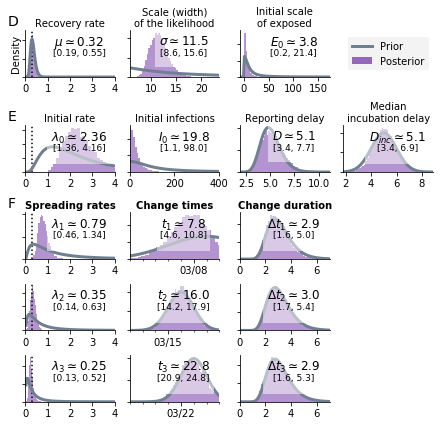

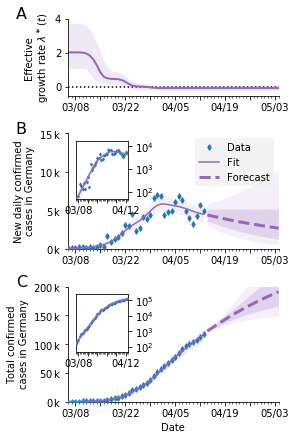

In [80]:
create_figure_3_distributions(model_not_rw, trace_not_rw, layout=2,
                              additional_insets = {'E_begin_scale': r"$E_0 \simeq ",
                                                   'median_incubation': r"$D_{inc} \simeq "}, 
                              xlim_lambda = (0, 4), color = 'tab:purple',
                              num_changepoints=3, save_to=path_to_save + 'Fig_SEIR_not_rw_distr')
create_figure_timeserie(trace_not_rw, 'tab:purple', num_days_fut_to_plot=21, y_lim_lambda = (-0.5, 4),
                       plot_red_axis=False, save_to=path_to_save + 'Fig_SEIR_not_rw_cases')

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1529: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


ValueError: x and y must have same first dimension, but have shapes (47,) and (60,)

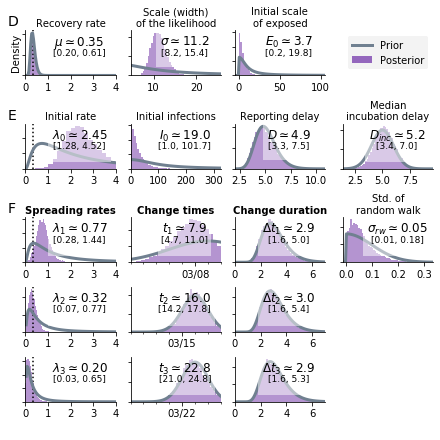

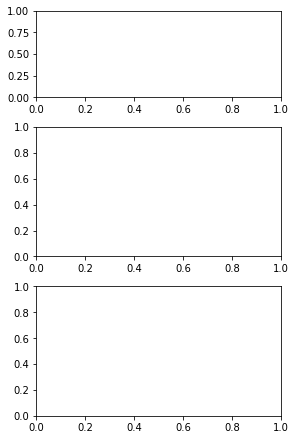

In [81]:
create_figure_3_distributions(model_rw, trace_rw, layout=2,
                              additional_insets = {'E_begin_scale': r"$E_0 \simeq ",
                                                   'median_incubation': r"$D_{inc} \simeq ",
                                                   'sigma_random_walk': r"$\sigma_{rw} \simeq "}, 
                              xlim_lambda = (0, 4), color = 'tab:purple',
                              num_changepoints=3, save_to=path_to_save + 'Fig_SEIR_rw_distr')
create_figure_timeserie(trace_rw, 'tab:purple', num_days_fut_to_plot=8, y_lim_lambda = (-0.5, 4),
                       plot_red_axis=False, save_to=path_to_save + 'Fig_SEIR_rw_cases')

In [83]:
print("With random walk \n")
print(pm.loo(trace_rw, model_rw))
print("Without random walk \n")
print(pm.loo(trace_not_rw, model_not_rw))

With random walk 

Computed from 12000 by 39 log-likelihood matrix

       Estimate       SE
IC_loo   612.28    15.85
p_loo      9.30        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       38   97.4%
 (0.5, 0.7]   (ok)          1    2.6%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Without random walk 

Computed from 12000 by 39 log-likelihood matrix

       Estimate       SE
IC_loo   613.93    15.83
p_loo      8.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       38   97.4%
 (0.5, 0.7]   (ok)          1    2.6%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

